# N-step learning
N-step learning is like traditional TD (Temporal Difference)-learning, except we do the $Reward(s,a)+\gamma Q(s',a')$ step more than once. In fact, N-step learning would be basically the same as TD-learning if $N=1$ ($N$ is the n. of steps we look-forward).

Since we'll be training on these new types of memory samples, our neural network will learn to predict the Q-value looking N steps ahead (except for those samples that end in less than N steps ahead; this is something we want anyway, because that should correlate with potentially less reward \[if it's strictly positive in this ex.\]).
- good resource: https://gibberblot.github.io/rl-notes/single-agent/n-step.html

## Initialization, imports

In [2]:
NB_ID = '07'

import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import clear_output

from typing import Dict, List, Tuple, Deque
from collections import deque

plt.ion()

## Replay buffer

In [3]:
class ReplayBuffer:
    # obs_size = state/observable space size
    def __init__(
        self, 
        max_size: int, 
        obs_size: int, 
        batch_size:int=32,
        n_step: int = 3,
        gamma: float = 0.99,
    ):
        self.state_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_size), dtype=np.float32)
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

        self.n_step_buffer = deque(max=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        transition = (state, action, reward, next_state, done)
        self.n_step_buffer.append(transition)

        if len(self.n_step_buffer) < self.n_step:
            # we don't have to flush the n_step buffer or anything like that
            # because it's a deque. see: https://www.geeksforgeeks.org/deque-in-python/
            return ()

        # at this point, we're now storing n-step transitions into memory
        reward, ns, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )

        # pair rew, n_s, done with a state and action that are at the start the chain
        state, action = self.n_step_buffer[0][:2]

        idx = self.ptr
        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]
    
    def sample(self) -> Dict[str, np.ndarray]:
        idxs = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idxs],
            action=self.action_buf[idxs],
            reward=self.reward_buf[idxs],
            ns=self.ns_buf[idxs],
            done=self.done_buf[idxs],
            idxs=idxs,
        )

    def sample_from_idxs(self, idxs: np.ndarray) -> Dict[str, np.ndarray]:
        return dict(
            state=self.state_buf[idxs],
            action=self.action_buf[idxs],
            reward=self.reward_buf[idxs],
            ns=self.ns_buf[idxs],
            done=self.done_buf[idxs],
            idxs=idxs,
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ):
        rew, next_state, done = n_step_buffer[-1][2:]

        # we calculate it backwards
        # this does not create correlations between different training sessions,
        # because by multiplying by (1-done) we mask the following training session anyway
        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_s, d = transition[2:]

            rew = r + self.gamma * (1-done) * rew
            # if our episode ends before this "chain" does, then next_state will be
            # the ending state, rather than that of the end of this chain of steps.
            next_state, done = (n_s, done) if d else next_state, done

        return rew, next_state, done

    def __len__(self):
        return self.size

## Network

In [4]:
class Network(nn.Module):
    def __init__(
        self,
        in_size,
        out_size
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

## Agent
I wonder if we could also store the n. of steps the deque of transitions for some sample went down (some may end prematurely) and then, when we're about to calculate the loss function, divide $gamma$ (parameter for `Agent.calculate_dqn`) by that instead of always dividing it by the size of the deque?

That would seem more correct to me. Just a thought!

In [5]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        eps_decay: float,
        max_eps: float = .9,
        min_eps: float = .1,
        gamma: float = .99,
        n_step: int = 3,
    ):
        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.eps_decay = eps_decay
        self.eps = max_eps
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.gamma = gamma
        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        self.use_n_step = True if n_step > 1 else False
        # like stated on the intro -- normal TD learning is just like n-step learning if `n_step=1``
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_size, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
        self.memory = ReplayBuffer(10000, obs_size, batch_size)

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        
        self.dqn = Network(obs_size, action_size).to(self.device)
        self.dqn_target = Network(obs_size, action_size).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # in the original tutorial, LR is not initialized.. but I think we're fine?
        # self.optimizer = optim.AdamW(self.dqn.parameters(), lr=self.lr, amsgrad=True)
        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

    def choose_action(self, state: np.ndarray) -> int:
        explore = self.eps > np.random.random()
        if explore:
            selected_action = self.env.action_space.sample()
        if not explore or self.is_test:
            selected_action = self.dqn(torch.FloatTensor(state)).argmax().item()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            if self.use_n_step:
                n_step_transition = self.memory_n.push(*self.transition)
                self.memory.push(*n_step_transition)
            else:
                # 1-step transition
                self.memory.push(*self.transition)
            
        return next_state, reward, done
    
    def compute_dqn(
        self, 
        samples: dict[str, np.array],
        gamma: float
    ):
        """calculate the DQN loss for a batch of memories"""
        device = self.device
        # each of these is a batch/samples of their corresponding name
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        reward = torch.FloatTensor(samples["reward"], device=device)
        done = torch.FloatTensor(samples["done"], device=device)

        curr_q_value = self.dqn(state).gather(1, action.unsqueeze(1))
        with torch.no_grad():
            next_q_value = self.dqn_target(ns).max(1)[0]
        mask = 1 - done
        target = (reward + next_q_value * gamma * mask).to(self.device)
        
        loss = F.smooth_l1_loss(curr_q_value.squeeze(), target)

        # # for debugging!
        # print('state', state[:2])
        # print('ns', ns[:2])
        # print('act', action[:2])
        # print('rew', reward[:2])
        # print('done', done[:2])
        # print('curr_q', curr_q_value[:2])
        # print('next_q', next_q_value[:2])
        # print('target', target[:2])

        return loss, torch.mean(curr_q_value).detach().numpy()
        
    def update_model(self) -> float:
        samples = self.memory.sample()

        loss, q_value = self.compute_dqn(samples)

        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item(), q_value

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            eff_episode = 0
            score = 0
            scores = []
            losses = []
            epsilons = []
            predictions = []
            
            for frame_idx in range(1, num_frames+1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                if done:
                    total_episodes += 1
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    eff_episode += 1
                    # linear decay
                    self.eps = max(self.min_eps, self.eps - (self.max_eps - self.min_eps) * self.eps_decay)
                    epsilons.append(self.eps)

                    if eff_episode % self.target_update == 0:
                        self.target_hard_update()

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{NB_ID}.s{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        # save current environment to swap it back later on
        naive_env = self.env
        
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, name_prefix=NB_ID)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons, predictions):

        clear_output(wait=True)
        # taking a lil different path from the tutorial
        # https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl
        # https://matplotlib.org/stable/_images/anatomy.png
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)

        ax1.set_title(f'frame {frame_idx} | score: {np.mean(scores[-10:])}')
        ax1.plot(scores)
        
        ax2.set_title('loss')
        ax2.plot(losses)

        ax3.set_title('Q value')
        ax3.plot(predictions)
        
        plt.show()


## Initializing environment

In [6]:
env_id = "CartPole-v1"
env = gym.make(env_id)

## Initializing environment

In [7]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initializing agent

In [8]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)

## Training

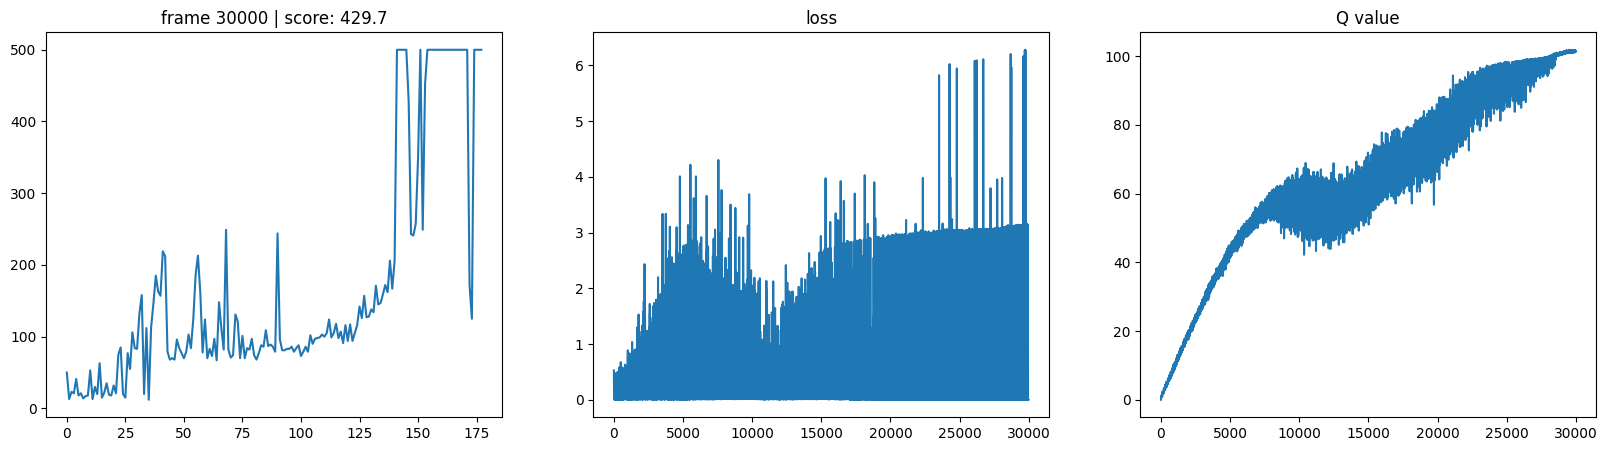

saved state!


In [9]:
agent.train(seed, num_frames)

## Training

In [ ]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-state/{NB_ID}.s{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)